In [1]:
! pip install tensorflow-datasets

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [7]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [30]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_info.features["label"].num_classes

10

In [11]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [17]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [18]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model


In [19]:
resnet_34 = build_resnet(is_50 = False)
resnet_50 = build_resnet(is_50 = True)
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

In [22]:
BATCH_SIZE = 256

In [24]:
EPOCH = 10

In [31]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [32]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

resnet_34.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   832         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 64)     0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [33]:
history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
195/195 [==============================] - 70s 100ms/step - loss: 1.9626 - accuracy: 0.3282 - val_loss: 3.1730 - val_accuracy: 0.1043
Epoch 2/10
195/195 [==============================] - 18s 95ms/step - loss: 1.5347 - accuracy: 0.4518 - val_loss: 2.7523 - val_accuracy: 0.1843
Epoch 3/10
195/195 [==============================] - 18s 91ms/step - loss: 1.3565 - accuracy: 0.5140 - val_loss: 1.5685 - val_accuracy: 0.4342
Epoch 4/10
195/195 [==============================] - 18s 91ms/step - loss: 1.2186 - accuracy: 0.5637 - val_loss: 1.4899 - val_accuracy: 0.4916
Epoch 5/10
195/195 [==============================] - 18s 93ms/step - loss: 1.1043 - accuracy: 0.6065 - val_loss: 1.4660 - val_accuracy: 0.4752
Epoch 6/10
195/195 [==============================] - 18s 93ms/step - loss: 1.0101 - accuracy: 0.6444 - val_loss: 1.4071 - val_accuracy: 0.5201
Epoch 7/10
195/195 [==============================] - 18s 92ms/step - loss: 0.9041 - accuracy: 0.6828 - val_loss: 1.3723 - val_accuracy

In [34]:
# 다른 모델 테스트
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

resnet_50.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   832         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 16, 16, 64)   256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)     0           batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [35]:
history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
195/195 [==============================] - 27s 94ms/step - loss: 2.0417 - accuracy: 0.3240 - val_loss: 3.3891 - val_accuracy: 0.1048
Epoch 2/10
195/195 [==============================] - 18s 91ms/step - loss: 1.5366 - accuracy: 0.4530 - val_loss: 2.5268 - val_accuracy: 0.2375
Epoch 3/10
195/195 [==============================] - 18s 92ms/step - loss: 1.3650 - accuracy: 0.5096 - val_loss: 1.7438 - val_accuracy: 0.3857
Epoch 4/10
195/195 [==============================] - 18s 92ms/step - loss: 1.2234 - accuracy: 0.5634 - val_loss: 1.4206 - val_accuracy: 0.4972
Epoch 5/10
195/195 [==============================] - 18s 93ms/step - loss: 1.1282 - accuracy: 0.5975 - val_loss: 1.3988 - val_accuracy: 0.5134
Epoch 6/10
195/195 [==============================] - 18s 92ms/step - loss: 1.0272 - accuracy: 0.6366 - val_loss: 1.4337 - val_accuracy: 0.5073
Epoch 7/10
195/195 [==============================] - 18s 92ms/step - loss: 0.9230 - accuracy: 0.6764 - val_loss: 1.3572 - val_accuracy:

In [36]:
# 다른 모델 테스트
plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
plain_resnet_34.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 64)   832         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 16, 16, 64)   256         conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 64)     0           batch_normalization_34[0][0]     
____________________________________________________________________________________________

In [37]:
history_plain_34 = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
195/195 [==============================] - 27s 94ms/step - loss: 2.0489 - accuracy: 0.3264 - val_loss: 3.0894 - val_accuracy: 0.1438
Epoch 2/10
195/195 [==============================] - 18s 92ms/step - loss: 1.5477 - accuracy: 0.4460 - val_loss: 2.5019 - val_accuracy: 0.2177
Epoch 3/10
195/195 [==============================] - 18s 93ms/step - loss: 1.3523 - accuracy: 0.5164 - val_loss: 1.5552 - val_accuracy: 0.4431
Epoch 4/10
195/195 [==============================] - 18s 92ms/step - loss: 1.2216 - accuracy: 0.5629 - val_loss: 1.4364 - val_accuracy: 0.4944
Epoch 5/10
195/195 [==============================] - 18s 92ms/step - loss: 1.1046 - accuracy: 0.6068 - val_loss: 1.4290 - val_accuracy: 0.5012
Epoch 6/10
195/195 [==============================] - 18s 92ms/step - loss: 0.9974 - accuracy: 0.6472 - val_loss: 1.3858 - val_accuracy: 0.5209
Epoch 7/10
195/195 [==============================] - 18s 92ms/step - loss: 0.9072 - accuracy: 0.6790 - val_loss: 1.4262 - val_accuracy:

In [38]:
# 다른 모델 테스트
plain_resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
plain_resnet_50.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 64)   832         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 16, 16, 64)   256         conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 8, 8, 64)     0           batch_normalization_51[0][0]     
____________________________________________________________________________________________

In [39]:
history_plain_50 = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
195/195 [==============================] - 27s 94ms/step - loss: 1.9788 - accuracy: 0.3286 - val_loss: 3.1473 - val_accuracy: 0.1054
Epoch 2/10
195/195 [==============================] - 18s 91ms/step - loss: 1.5583 - accuracy: 0.4474 - val_loss: 2.6016 - val_accuracy: 0.2076
Epoch 3/10
195/195 [==============================] - 18s 93ms/step - loss: 1.3723 - accuracy: 0.5092 - val_loss: 1.8232 - val_accuracy: 0.3921
Epoch 4/10
195/195 [==============================] - 18s 93ms/step - loss: 1.2318 - accuracy: 0.5589 - val_loss: 1.4312 - val_accuracy: 0.4970
Epoch 5/10
195/195 [==============================] - 18s 93ms/step - loss: 1.1093 - accuracy: 0.6054 - val_loss: 1.3817 - val_accuracy: 0.5229
Epoch 6/10
195/195 [==============================] - 18s 92ms/step - loss: 1.0051 - accuracy: 0.6468 - val_loss: 1.3927 - val_accuracy: 0.5200
Epoch 7/10
195/195 [==============================] - 18s 93ms/step - loss: 0.9086 - accuracy: 0.6826 - val_loss: 1.4637 - val_accuracy:

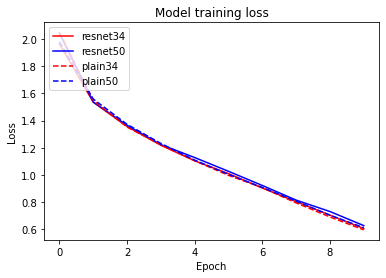

In [46]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'r', linestyle='--')
plt.plot(history_plain_50.history['loss'], 'b', linestyle='--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50','plain34', 'plain50'], loc='upper left')
plt.show()

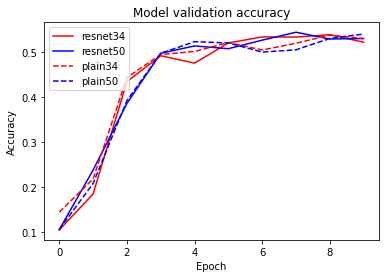

In [45]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'r', linestyle='--')
plt.plot(history_plain_50.history['val_accuracy'], 'b', linestyle='--')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50','plain34', 'plain50'], loc='upper left')
plt.show()